In [ ]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import os
from scipy import stats
from straxen import units
from scipy.ndimage import gaussian_filter1d
import drift_diffusion_utility as ddu

Start import


In [ ]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning_kr*',
                       available=('event_info','peak_basics'))

Checking data availability: 100%|██████████| 3/3 [12:27<00:00, 249.03s/it]


In [4]:
dsets_1 = dsets[(dsets.end > pd.to_datetime('01/23/2021')) & (dsets.number<12245) & (dsets.livetime>np.timedelta64(30,'m'))]
run_1, nn_1 = np.array(dsets_1['name']), len(dsets_1)
dsets_2 = dsets[(dsets.number>=12245) & (dsets.number<=12443) & (dsets.livetime>np.timedelta64(30,'m'))]
run_2, nn_2 = np.array(dsets_2['name']), len(dsets_2)
print('Number of runs:\n',nn_1,'with liquid level at 4.8 mm\n',nn_2,'with liquid level at 5.5 mm')

Number of runs:
 40 with liquid level at 4.8 mm
 106 with liquid level at 5.5 mm


In [61]:
def drift_time_calculation( run_kr, plot = False ):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    #if(plot): ddu.plot_area_width_aft(events, run_kr)
    mask_singleS1 = ddu.mask_KrSingleS1(events)
    #if(plot): plot_area_width_aft(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    vd, vd_err, cathodedt, gatedt = drift_velocity(e1, run_kr, plot=plot)
    if ((cathodedt>2000) & (gatedt>2)): return run, vd, vd_err, cathodedt, gatedt
    else: return run, 0,0,0,0

Drift velocity = 0.629~mm/$\mu$s


(12130,
 0.6293309692840389,
 0.0026611880215644573,
 2364.849699398798,
 5.201005025125628)

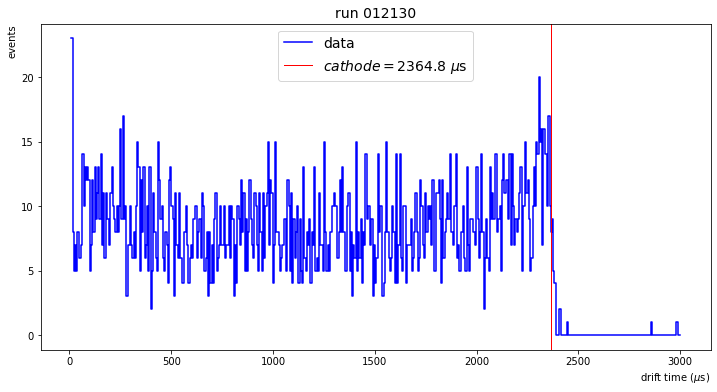

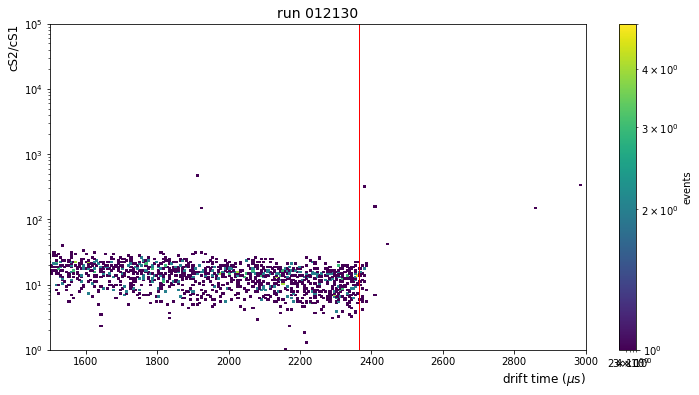

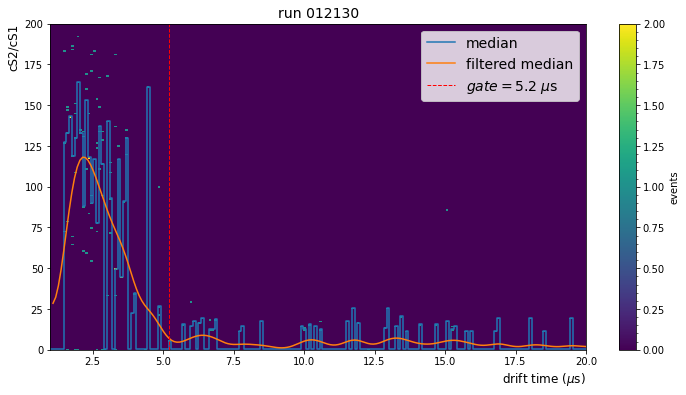

In [62]:
drift_time_calculation( run_kr = '012130', plot = True)

Drift velocity = 0.629~mm/$\mu$s


(12245,
 0.6294583167053025,
 0.002661726522684829,
 2364.849699398798,
 5.6783919597989945)

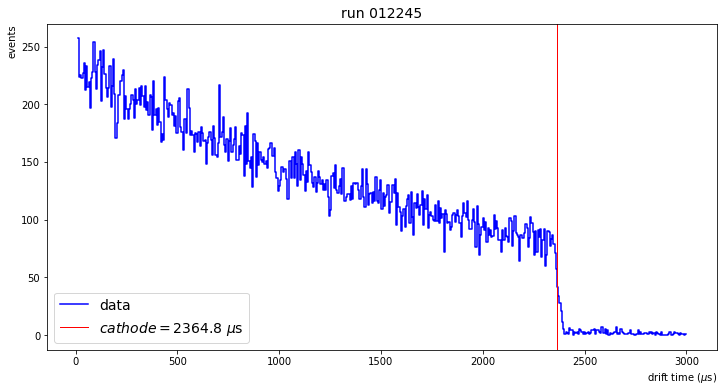

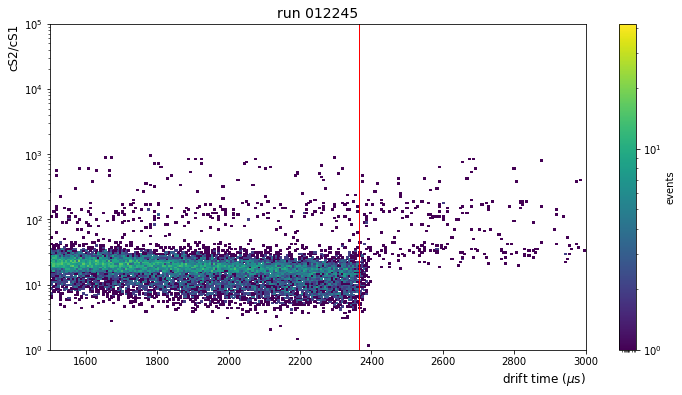

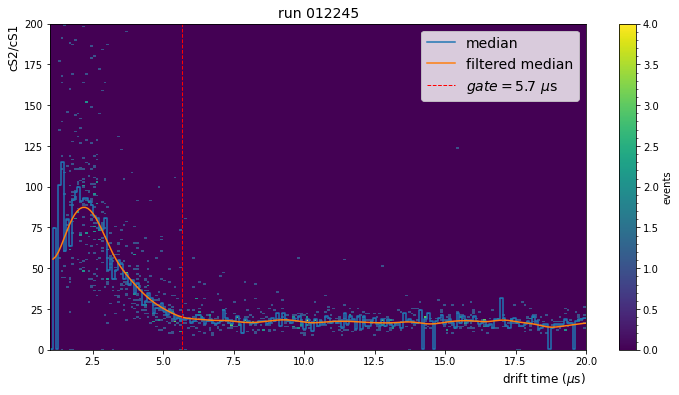

In [63]:
drift_time_calculation( run_kr = '012245', plot = True)

In [64]:
runs, vd, vd_err, cathode, gate = np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1), np.zeros(nn_1)
for i, run in enumerate(run_1):
    runs[i], vd[i], vd_err[i], cathode[i], gate[i] = drift_time_calculation(run)

In [65]:
runs2, vd2, vd2_err, cathode2, gate2 = np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2), np.zeros(nn_2)
for i, run in enumerate(run_2):
    runs2[i], vd2[i], vd2_err[i], cathode2[i], gate2[i] = drift_time_calculation(run)

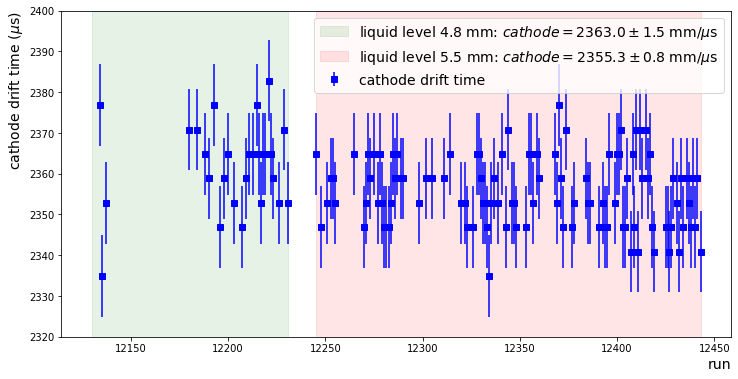

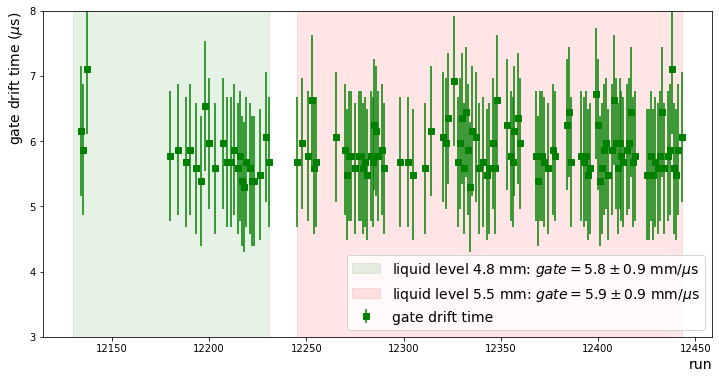

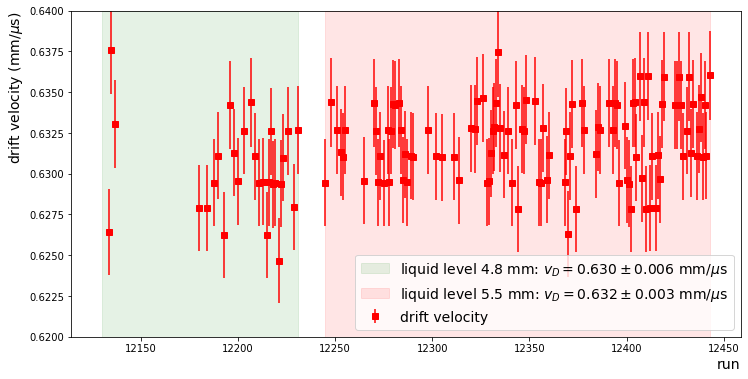

In [66]:
rr, vdd, vdd_err, cc, gg = np.concatenate((runs,runs2)), np.concatenate((vd,vd2)), np.concatenate((vd_err,vd2_err)), np.concatenate((cathode,cathode2)), np.concatenate((gate,gate2))
### cathode drop-off
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("cathode drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,cc,yerr=10,fmt='s',color='b',label='cathode drift time')
cm1, cm2 = cathode[cathode>2340].mean(), cathode2[cathode2>0].mean()
cs1, cs2 = cathode[cathode>2340].std()/np.sqrt(np.size(cathode)), cathode2[cathode2>2340].std()/np.sqrt(np.size(cathode2))
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $cathode = {cm1:.1f} \pm {cs1:.1f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $cathode = {cm2:.1f} \pm {cs2:.1f}$ mm/$\mu$s')
plt.ylim(2320,2400)
plt.legend(fontsize=14)

### gate drift time
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("gate drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,gg,yerr=1,fmt='s',color='g',label='gate drift time')
gm1, gm2 = gate[gate>0].mean(), gate2[gate2>0].mean()
gs1, gs2 = (gate[gate>0].max()-gate[gate>0].min())/2, (gate2[gate2>0].max()-gate2[gate2>0].min())/2
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $gate = {gm1:.1f} \pm {gs1:.1f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $gate = {gm2:.1f} \pm {gs2:.1f}$ mm/$\mu$s')
plt.legend(fontsize=14)
plt.ylim(3,8)

# drif velocity
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("drift velocity (mm/$\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr,vdd,yerr=vdd_err,fmt='s',color='r',label='drift velocity')
m1, m2 = vd[vd>0].mean(), vd2[vd2>0].mean()
s1, s2 = vd[vd>0].std()/np.sqrt(np.size(vd))+vd_err[vd>0].mean()+vd_err[vd>0].mean(), vd2[vd2>0].std()/np.sqrt(np.size(vd2))+vd2_err[vd2>0].mean()
plt.axvspan(12130,12231, alpha=0.1, color='g',
            label=f'liquid level 4.8 mm: $v_D = {m1:.3f} \pm {s1:.3f}$ mm/$\mu$s')
plt.axvspan(12245,12443, alpha=0.1, color='r',
            label=f'liquid level 5.5 mm: $v_D = {m2:.3f} \pm {s2:.3f}$ mm/$\mu$s')
plt.ylim(0.62,0.64)
plt.legend(fontsize=14)

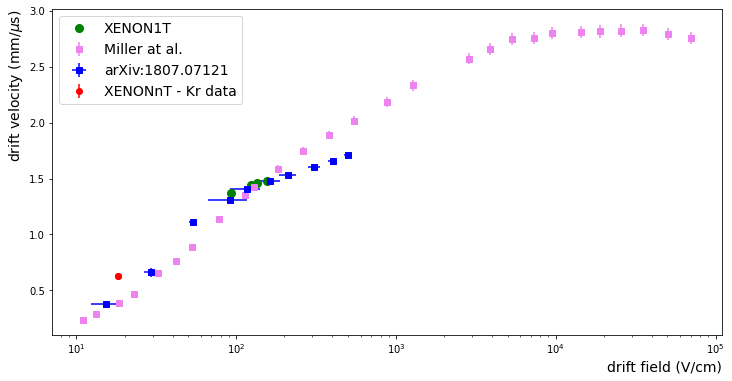

In [67]:
with open("DriftVelocity.txt") as f:
    data = f.read()
data = data.split('\n')
ind = [row.split('\t')[0] for row in data]
dt = [row.split('\t')[1] for row in data]
dv = [row.split('\t')[2] for row in data]
dt, dv = np.array(dt, dtype=np.float32), np.array(dv, dtype=np.float32)

with open("DriftVelocity-Hogenbirk.txt") as f:
    data2 = f.read()
data2 = data2.split('\n')
ff = [row.split(' ')[0] for row in data2]
dd = [row.split(' ')[1] for row in data2]
fe = [row.split(' ')[2] for row in data2]
de = [row.split(' ')[3] for row in data2]
ff, fe = np.array(ff, dtype=np.float32), np.array(fe, dtype=np.float32)
dd, de = np.array(dd, dtype=np.float32), np.array(de, dtype=np.float32)
plt.figure(figsize=(12,6))
plt.errorbar(dt,dv,yerr=dv*0.02, c='violet', fmt='s', label='Miller at al.')
plt.errorbar(ff,dd,xerr=fe,yerr=de, c='b', fmt='s', label='arXiv:1807.07121') 
plt.xlabel('drift field (V/cm)',ha='right',x=1,fontsize=14)
plt.ylabel('drift velocity (mm/$\mu$s)',ha='right',y=1,fontsize=14)
plt.xscale('log')
field_nT, vd_nT, vd_nT_err = [18.3,18.3], [m1,m2], [s1,s2]
plt.errorbar(field_nT,vd_nT,yerr=vd_nT_err,fmt='o',color='r',label='XENONnT - Kr data')
field_1T, vd_1T = [155,134,124,92.8], [1.482,1.456,1.440,1.371]
plt.plot(field_1T,vd_1T,marker='o',c='g',ms=8,lw=0,label='XENON1T')
plt.legend(fontsize=14)